In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
#endpoint = 'https://min-api.cryptocompare.com/data/histoday'
endpoint= 'https://min-api.cryptocompare.com/data/histohour'
res = requests.get(endpoint + '?fsym=ETH&tsym=BTC&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.tail(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2020-05-22 19:00:00,0.02264,0.02268,0.02256,0.02262,30807.76,696.69
2020-05-22 20:00:00,0.02268,0.02271,0.02261,0.02264,19376.75,438.90
2020-05-22 21:00:00,0.02264,0.02271,0.02263,0.02268,18346.92,415.93
2020-05-22 22:00:00,0.02265,0.02268,0.02261,0.02264,34715.82,786.29
2020-05-22 23:00:00,0.02263,0.02265,0.02262,0.02265,993.95,22.50


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

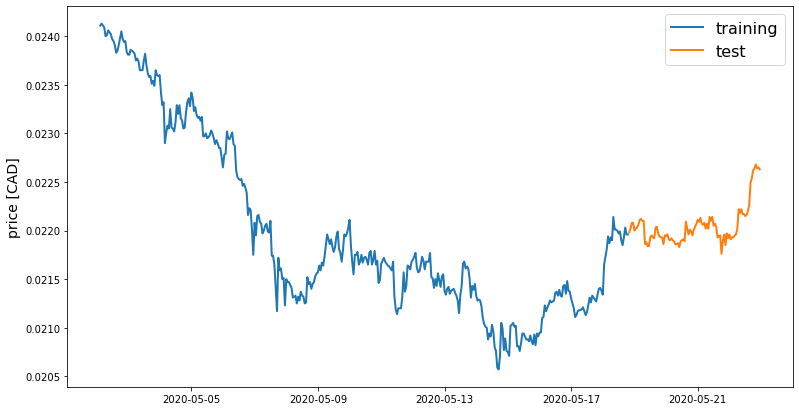

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [6]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [7]:
def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [9]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
np.random.seed(42)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [11]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 2/20
391/391 [==============================] - 0s 576us/step - loss: 0.0026
Epoch 3/20
391/391 [==============================] - 0s 592us/step - loss: 0.0018
Epoch 4/20
391/391 [==============================] - 0s 554us/step - loss: 0.0018
Epoch 5/20
391/391 [==============================] - 0s 574us/step - loss: 0.0012
Epoch 6/20
391/391 [==============================] - 0s 578us/step - loss: 0.0012
Epoch 7/20
391/391 [==============================] - 0s 617us/step - loss: 7.4812e-04
Epoch 8/20
391/391 [==============================] - 0s 589us/step - loss: 9.5551e-04
Epoch 9/20
391/391 [==============================] - 0s 612us/step - loss: 5.8244e-04
Epoch 10/20
391/391 [==============================] - 0s 583us/step - loss: 5.3173e-04
Epoch 11/20
391/391 [==============================] - 0s 608us/step - loss: 4.8458e-04
Epoch 12/20
391/391 [==============================] - 0s 605us/ste

In [12]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
# 0.04

0.006015691550920437

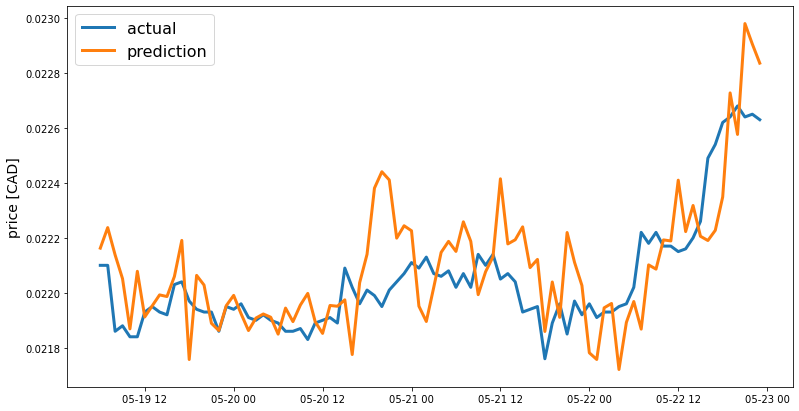

In [13]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)